In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

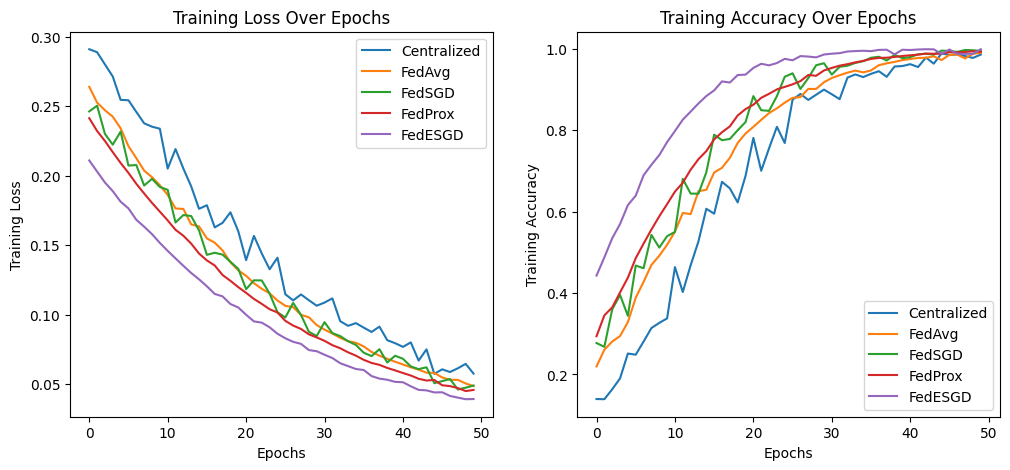

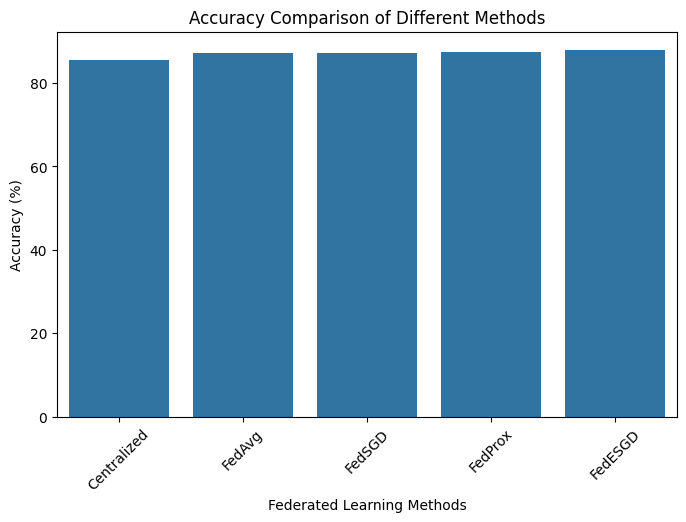

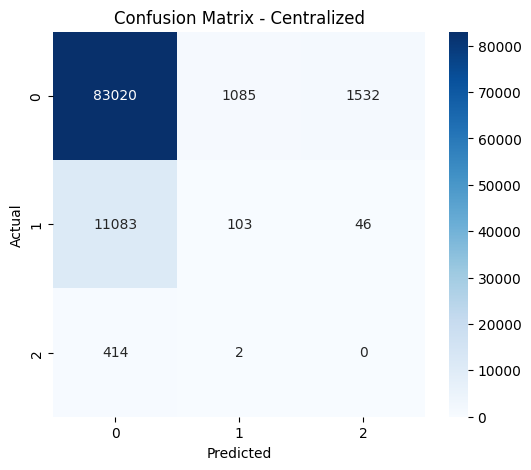

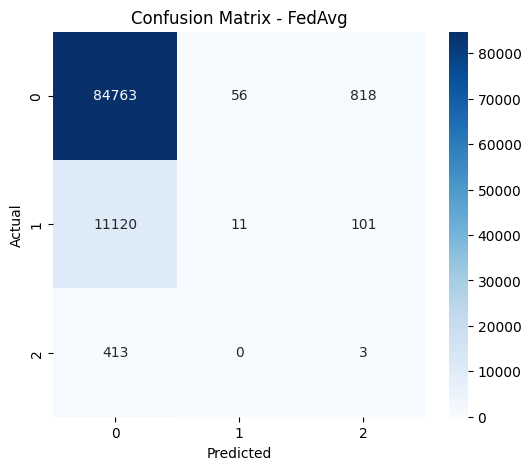

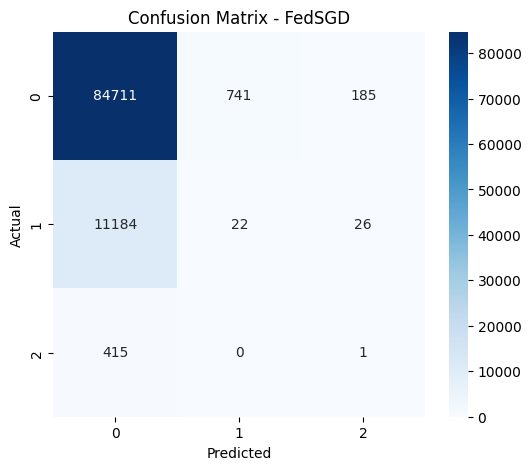

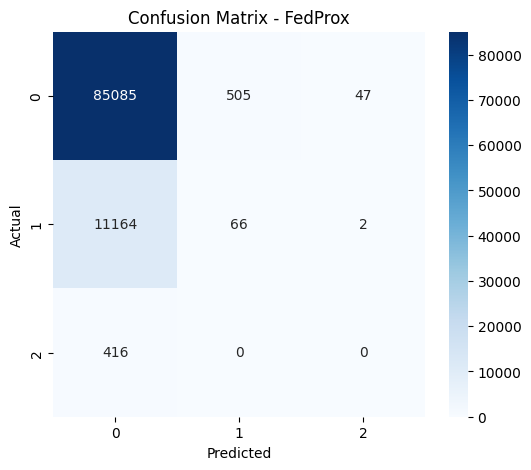

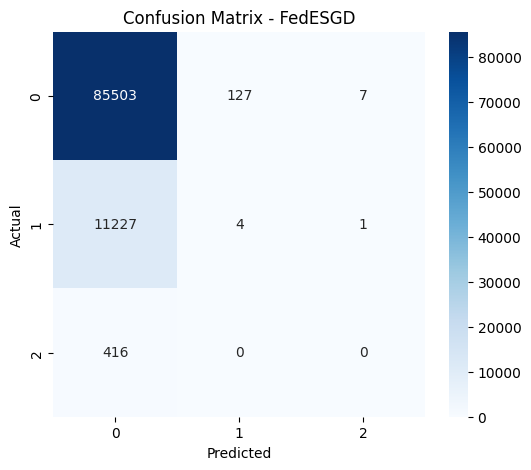


Centralized Model Accuracy: 85.44%
Confusion Matrix for Centralized:
[[83020  1085  1532]
 [11083   103    46]
 [  414     2     0]]
Classification Report for Centralized:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     85637
           1       0.09      0.01      0.02     11232
           2       0.00      0.00      0.00       416

    accuracy                           0.85     97285
   macro avg       0.32      0.33      0.31     97285
weighted avg       0.78      0.85      0.81     97285


FedAvg Model Accuracy: 87.14%
Confusion Matrix for FedAvg:
[[84763    56   818]
 [11120    11   101]
 [  413     0     3]]
Classification Report for FedAvg:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     85637
           1       0.16      0.00      0.00     11232
           2       0.00      0.01      0.00       416

    accuracy                           0.87     97285
   macro avg    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.special import softmax
import random
import pickle

# Load Dataset
file_path = "/Users/uday/Downloads/mydata1.csv"
df = pd.read_csv(file_path, delimiter=",", on_bad_lines="skip", low_memory=False)

# Ensure sequences have a fixed length
SEQ_LENGTH = 10  

def one_hot_encode(seq, length=SEQ_LENGTH):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    encoded = np.array([mapping.get(nuc, [0, 0, 0, 0]) for nuc in seq[:length]])
    if len(encoded) < length:
        padding = np.zeros((length - len(encoded), 4))
        encoded = np.vstack((encoded, padding))
    return encoded.flatten()

# Apply encoding
df['Forward_Sequence'] = df['Forward_Sequence'].astype(str).apply(lambda x: one_hot_encode(x))
df['SourceSeq'] = df['SourceSeq'].astype(str).apply(lambda x: one_hot_encode(x))

# Convert features
df['MAPINFO'] = pd.to_numeric(df['MAPINFO'], errors='coerce').fillna(0.0)
df['Strand'] = df['Strand'].map({'+': 1, '-': 0}).fillna(0).astype(int)
df['CHR'] = df['CHR'].map({'X': 23, 'Y': 24, 'MT': 25}).fillna(-1).astype(int)
df['MAPINFO'] = (df['MAPINFO'] - df['MAPINFO'].mean()) / df['MAPINFO'].std()

# Prepare feature matrix X and target y
X = np.stack(df[['MAPINFO', 'Strand']].values)
one_hot_features = np.stack(df['Forward_Sequence'].values)
source_seq_features = np.stack(df['SourceSeq'].values)
X = np.hstack([X, one_hot_features, source_seq_features])

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df[['CHR']])

# Split train-test
test_size = len(X) // 5
X_train, X_test = X[test_size:], X[:test_size]
y_train, y_test = y[test_size:], y[:test_size]

# Non-IID Data Distribution
num_clients = 5
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Federated Learning Techniques
lr = 0.01
num_epochs = 50
mu = 0.01  # FedProx parameter

def train_local(X, y, weights, epochs, lr, method='FedAvg', mu=0.01):
    losses, accuracies = [], []
    for epoch in range(epochs):
        z = np.dot(X, weights)
        predictions = softmax(z, axis=1)
        error = predictions - y
        grad = np.dot(X.T, error) / len(X)
        if method == 'FedProx':
            grad += mu * (weights - np.mean(weights))  # FedProx Regularization
        weights -= lr * grad
        
        loss = np.mean(np.square(error))
        acc = accuracy_score(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
        losses.append(loss)
        accuracies.append(acc)
    return weights, losses, accuracies

input_size = X.shape[1]
num_classes = y.shape[1]

# Training different models individually
models = {}
training_stats = {}

for method in ['Centralized', 'FedAvg', 'FedSGD', 'FedProx', 'FedESGD']:
    weights = np.random.randn(input_size, num_classes) * np.sqrt(1 / input_size)
    losses, accuracies = [], []
    for round in range(num_epochs):
        local_weights = []
        selected_clients = random.sample(range(num_clients), k=3)
        for i in selected_clients:
            local_w, loss, acc = train_local(client_data[i], client_labels[i], weights.copy(), 1, lr, method)
            local_weights.append(local_w)
        
        if method == 'Centralized':
            weights = local_weights[-1]
        else:
            weights = np.mean(local_weights, axis=0)
        
        losses.append(loss[-1])
        accuracies.append(acc[-1])
    
    models[method] = weights
    training_stats[method] = {'loss': losses, 'accuracy': accuracies}

# Evaluate Models
def evaluate_model(weights, X_test, y_test):
    y_pred = np.argmax(softmax(np.dot(X_test, weights), axis=1), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    return {
        'accuracy': accuracy_score(y_test_labels, y_pred),
        'conf_matrix': confusion_matrix(y_test_labels, y_pred),
        'classification_report': classification_report(y_test_labels, y_pred)
    }

evaluation_results = {method: evaluate_model(models[method], X_test, y_test) for method in models}

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for method in training_stats:
    plt.plot(training_stats[method]['loss'], label=method)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Over Epochs')

plt.subplot(1, 2, 2)
for method in training_stats:
    plt.plot(training_stats[method]['accuracy'], label=method)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy Over Epochs')
plt.show()

# Bar Chart for Accuracy Comparison
methods = list(evaluation_results.keys())
accuracies = [evaluation_results[m]['accuracy'] * 100 for m in methods]
plt.figure(figsize=(8, 5))
sns.barplot(x=methods, y=accuracies)
plt.xlabel("Federated Learning Methods")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of Different Methods")
plt.xticks(rotation=45)
plt.show()

# Confusion Matrix Heatmap
for method in evaluation_results:
    plt.figure(figsize=(6, 5))
    sns.heatmap(evaluation_results[method]['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {method}")
    plt.show()

# Print Results
for method, result in evaluation_results.items():
    print(f"\n{method} Model Accuracy: {result['accuracy'] * 100:.2f}%")
    print(f"Confusion Matrix for {method}:\n{result['conf_matrix']}")
    print(f"Classification Report for {method}:\n{result['classification_report']}")



import pickle

# Find the best-performing model
best_method = max(evaluation_results, key=lambda m: evaluation_results[m]['accuracy'])
best_model = models[best_method]

# Save the best model
best_model_path = "best_model1.pkl"
with open(best_model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"\n🎯 Best Model: {best_method} (Accuracy: {evaluation_results[best_method]['accuracy'] * 100:.2f}%)")
print(f"✅ Saved best model as {best_model_path}")



In [ ]:
import numpy as np
import pickle
import os
import time
from phe import paillier  # Paillier Encryption

# Define file names
best_model_name = "best_model1.pkl"
keys_path = "paillier_keys.pkl"

# Generate or load Paillier key pair
if os.path.exists(keys_path):
    with open(keys_path, "rb") as f:
        public_key, private_key = pickle.load(f)  # Unpack tuple
    print("✅ Loaded Paillier Key Pair!")
else:
    public_key, private_key = paillier.generate_paillier_keypair()
    with open(keys_path, "wb") as f:
        pickle.dump((public_key, private_key), f)  # Store as tuple
    print("🔑 Generated New Paillier Key Pair!")

# Load the best model if it exists
if os.path.exists(best_model_name):
    with open(best_model_name, "rb") as f:
        global_model = pickle.load(f)
    print(f"✅ Loaded Best Model from {best_model_name}!")
else:
    input_size, num_classes = 82, 24  # Adjust as needed
    global_model = np.random.randn(input_size, num_classes) * np.sqrt(1 / input_size)
    print(f"🚀 Initialized New Model!")

print("\n🌍 Server is running and waiting for encrypted client updates...")

# Listen for encrypted client updates
client_update_path = "client_update.pkl"

# Wait for client update
while not os.path.exists(client_update_path):
    time.sleep(1)  # Prevent high CPU usage

# Load encrypted client weights
with open(client_update_path, "rb") as f:
    encrypted_client_weights = pickle.load(f)

print("\n📩 Received Encrypted Update from Client!")

# Decrypt Client Weights and Reshape Correctly
client_weights_flat = np.array([
    private_key.decrypt(weight) for weight in encrypted_client_weights
])

# Reshape to match global_model's shape
client_weights = client_weights_flat.reshape(global_model.shape)

print(f"🔢 Decrypted Client Weights (First 10 Values): {client_weights.flatten()[:10]}")


# Federated Averaging (FedAvg) aggregation
global_model = (global_model + client_weights) / 2

# Save updated best model
with open(best_model_name, "wb") as f:
    pickle.dump(global_model, f)

print(f"\n✅ Best Model updated successfully!")

# Remove processed client update
os.remove(client_update_path)


✅ Loaded Paillier Key Pair!
✅ Loaded Best Model from best_model1.pkl!

🌍 Server is running and waiting for encrypted client updates...

📩 Received Encrypted Update from Client!
🔢 Decrypted Client Weights (First 10 Values): [-0.02309297  0.15455538 -0.09729904  0.13333844  0.10997653  0.09788008
  0.19906405 -0.08622122 -0.0128474  -0.1131673 ]

✅ Best Model updated successfully!


In [3]:
!python3 -m pip install phe

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pvporcupine-3.0.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [30]:
import numpy as np
import pickle
import os
from phe import paillier  # Paillier Encryption

# Define file names
best_model_name = "best_model1.pkl"
keys_path = "paillier_keys.pkl"
client_update_path = "client_update.pkl"

# Wait until the global model is available
if not os.path.exists(best_model_name):
    print(f"❌ No best model found. Please run the server first!")
    exit()

# Load the best global model
with open(best_model_name, "rb") as f:
    global_weights = pickle.load(f)

print("\n🤖 Client started training on local data...")

# Print global model before training
print(f"\n🟢 Global Model Before Training (First 10 Values): {global_weights.flatten()[:10]}")

# Simulated local training (updating weights slightly)
client_weights = global_weights + np.random.randn(*global_weights.shape) * 0.01

print("\n✅ Local training completed!")
print(f"🔢 Updated Weights After Training (First 10 Values): {client_weights.flatten()[:10]}")

# Load Paillier Public Key
if not os.path.exists(keys_path):
    print(f"❌ Paillier key file missing! Ensure the server has generated keys.")
    exit()

with open(keys_path, "rb") as f:
    public_key, _ = pickle.load(f)  # Load only the public key

# Encrypt the Client Weights
encrypted_client_weights = np.array([
    public_key.encrypt(weight) for weight in client_weights.flatten()
])

print("\n🔐 Client weights encrypted successfully!")

# Save encrypted update to send to server
with open(client_update_path, "wb") as f:
    pickle.dump(encrypted_client_weights, f)

print("\n📤 Sending encrypted update to the server...")
print(f"✅ Encrypted Update Sent Successfully!")



🤖 Client started training on local data...

🟢 Global Model Before Training (First 10 Values): [-0.02355936  0.15266125 -0.09213015  0.1279158   0.11519042  0.09716946
  0.19936461 -0.10426734 -0.02183827 -0.11952433]

✅ Local training completed!
🔢 Updated Weights After Training (First 10 Values): [-0.02309297  0.15455538 -0.09729904  0.13333844  0.10997653  0.09788008
  0.19906405 -0.08622122 -0.0128474  -0.1131673 ]

🔐 Client weights encrypted successfully!

📤 Sending encrypted update to the server...
✅ Encrypted Update Sent Successfully!


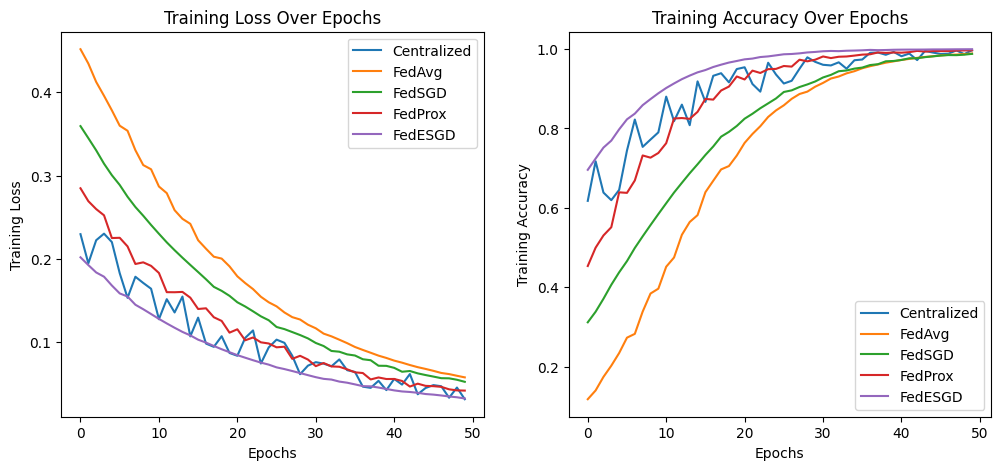

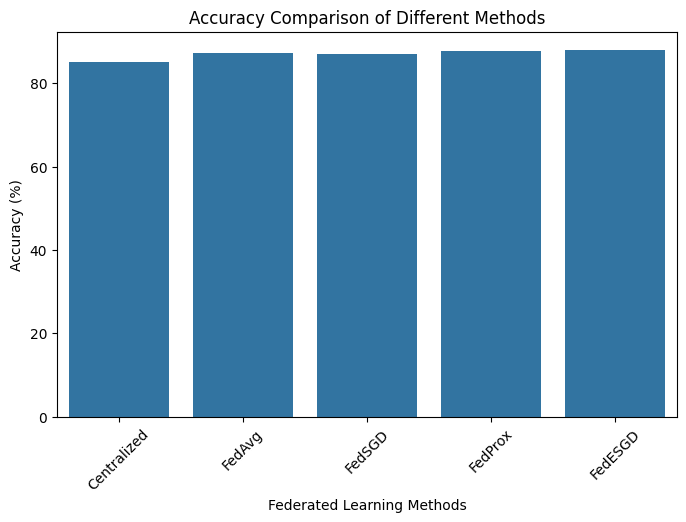

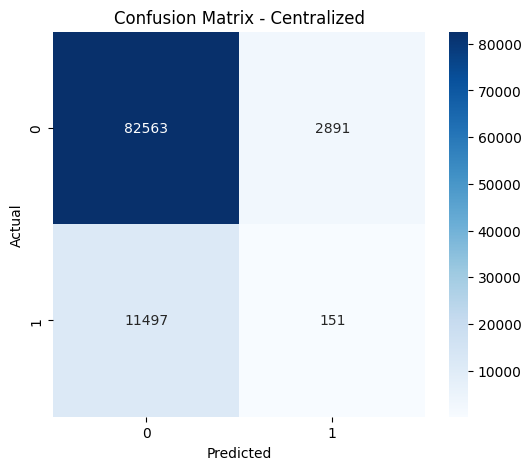

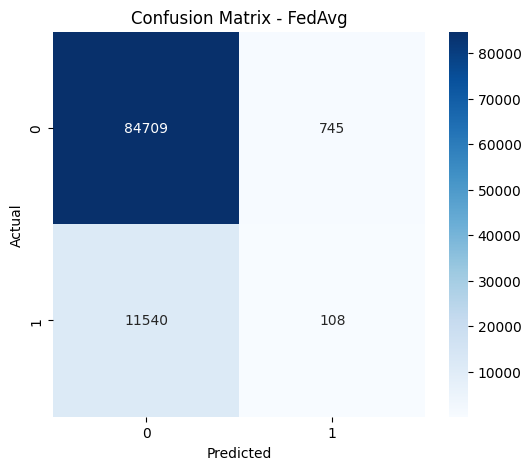

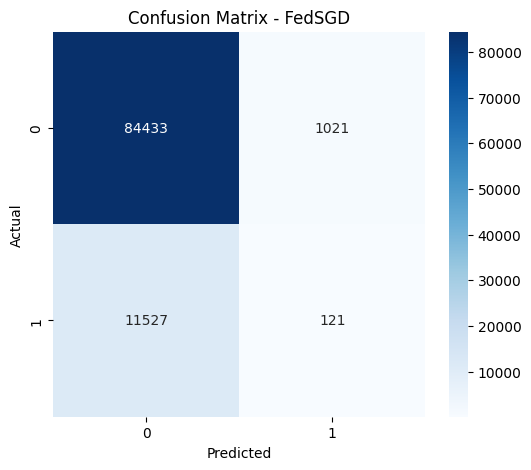

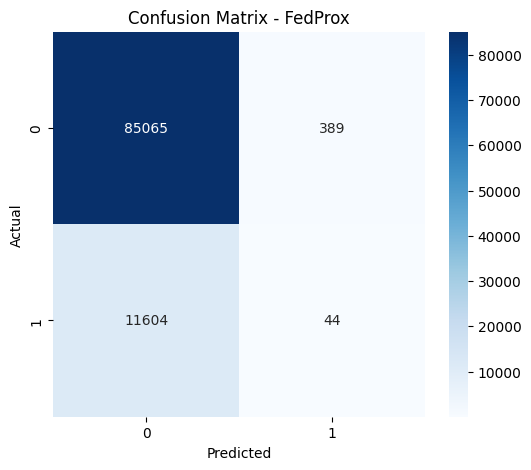

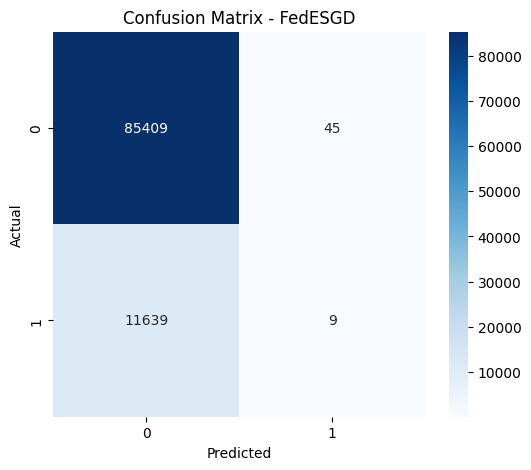


Centralized Model Accuracy: 85.18%
Confusion Matrix for Centralized:
[[82563  2891]
 [11497   151]]
Classification Report for Centralized:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     85454
           1       0.05      0.01      0.02     11648

    accuracy                           0.85     97102
   macro avg       0.46      0.49      0.47     97102
weighted avg       0.78      0.85      0.81     97102


FedAvg Model Accuracy: 87.35%
Confusion Matrix for FedAvg:
[[84709   745]
 [11540   108]]
Classification Report for FedAvg:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     85454
           1       0.13      0.01      0.02     11648

    accuracy                           0.87     97102
   macro avg       0.50      0.50      0.47     97102
weighted avg       0.79      0.87      0.82     97102


FedSGD Model Accuracy: 87.08%
Confusion Matrix for FedSGD:
[[84433  1021]
 [1152

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.special import softmax
import random
import pickle

# Load Dataset
file_path = "/Users/uday/Downloads/mydata1.csv"
df = pd.read_csv(file_path, delimiter=",", on_bad_lines="skip", low_memory=False)

# Encode Chromosome Column (Binary Classification: 0 = Autosomes, 1 = Sex Chromosomes)
def encode_chromosome(chrom):
    if str(chrom).isdigit() and 1 <= int(chrom) <= 22:
        return 0  # Autosomes
    elif chrom in ['X', 'Y']:
        return 1  # Sex Chromosomes
    return -1  # Unknown

df['CHR'] = df['CHR'].apply(encode_chromosome)
df = df[df['CHR'] != -1]  # Remove unknown values

# Feature Engineering
SEQ_LENGTH = 10
def one_hot_encode(seq, length=SEQ_LENGTH):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    encoded = np.array([mapping.get(nuc, [0, 0, 0, 0]) for nuc in seq[:length]])
    if len(encoded) < length:
        padding = np.zeros((length - len(encoded), 4))
        encoded = np.vstack((encoded, padding))
    return encoded.flatten()

df['Forward_Sequence'] = df['Forward_Sequence'].astype(str).apply(one_hot_encode)
df['SourceSeq'] = df['SourceSeq'].astype(str).apply(one_hot_encode)

df['MAPINFO'] = pd.to_numeric(df['MAPINFO'], errors='coerce').fillna(0.0)
df['Strand'] = df['Strand'].map({'+': 1, '-': 0}).fillna(0).astype(int)
df['MAPINFO'] = (df['MAPINFO'] - df['MAPINFO'].mean()) / df['MAPINFO'].std()

# Prepare feature matrix X and target y
X = np.stack(df[['MAPINFO', 'Strand']].values)
one_hot_features = np.stack(df['Forward_Sequence'].values)
source_seq_features = np.stack(df['SourceSeq'].values)
X = np.hstack([X, one_hot_features, source_seq_features])

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df[['CHR']])

# Split Data into Training and Testing
test_size = len(X) // 5
X_train, X_test = X[test_size:], X[:test_size]
y_train, y_test = y[test_size:], y[:test_size]

# Federated Learning Setup
num_clients = 5
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Training Hyperparameters
lr = 0.01
num_epochs = 50
mu = 0.01  # FedProx parameter

def train_local(X, y, weights, epochs, lr, method='FedAvg', mu=0.01):
    losses, accuracies = [], []
    for epoch in range(epochs):
        z = np.dot(X, weights)
        predictions = softmax(z, axis=1)
        error = predictions - y
        grad = np.dot(X.T, error) / len(X)
        if method == 'FedProx':
            grad += mu * (weights - np.mean(weights))  # FedProx Regularization
        weights -= lr * grad
        
        loss = np.mean(np.square(error))
        acc = accuracy_score(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
        losses.append(loss)
        accuracies.append(acc)
    return weights, losses, accuracies

input_size = X.shape[1]
num_classes = y.shape[1]

# Train Different Federated Learning Models
models = {}
training_stats = {}

for method in ['Centralized', 'FedAvg', 'FedSGD', 'FedProx', 'FedESGD']:
    weights = np.random.randn(input_size, num_classes) * np.sqrt(1 / input_size)
    losses, accuracies = [], []
    
    for round in range(num_epochs):
        local_weights = []
        selected_clients = random.sample(range(num_clients), k=3)  # Select 3 random clients per round
        
        for i in selected_clients:
            local_w, loss, acc = train_local(client_data[i], client_labels[i], weights.copy(), 1, lr, method)
            local_weights.append(local_w)
        
        # Model Aggregation
        if method == 'Centralized':
            weights = local_weights[-1]  # Use the last trained model
        else:
            weights = np.mean(local_weights, axis=0)  # FedAvg-style aggregation
        
        losses.append(loss[-1])
        accuracies.append(acc[-1])
    
    models[method] = weights
    training_stats[method] = {'loss': losses, 'accuracy': accuracies}

# Evaluate Models
def evaluate_model(weights, X_test, y_test):
    y_pred = np.argmax(softmax(np.dot(X_test, weights), axis=1), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    return {
        'accuracy': accuracy_score(y_test_labels, y_pred),
        'conf_matrix': confusion_matrix(y_test_labels, y_pred),
        'classification_report': classification_report(y_test_labels, y_pred)
    }

evaluation_results = {method: evaluate_model(models[method], X_test, y_test) for method in models}

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for method in training_stats:
    plt.plot(training_stats[method]['loss'], label=method)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Over Epochs')

plt.subplot(1, 2, 2)
for method in training_stats:
    plt.plot(training_stats[method]['accuracy'], label=method)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy Over Epochs')
plt.show()

# Bar Chart for Accuracy Comparison
methods = list(evaluation_results.keys())
accuracies = [evaluation_results[m]['accuracy'] * 100 for m in methods]
plt.figure(figsize=(8, 5))
sns.barplot(x=methods, y=accuracies)
plt.xlabel("Federated Learning Methods")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of Different Methods")
plt.xticks(rotation=45)
plt.show()

# Confusion Matrix Heatmap
for method in evaluation_results:
    plt.figure(figsize=(6, 5))
    sns.heatmap(evaluation_results[method]['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {method}")
    plt.show()

# Print Results
for method, result in evaluation_results.items():
    print(f"\n{method} Model Accuracy: {result['accuracy'] * 100:.2f}%")
    print(f"Confusion Matrix for {method}:\n{result['conf_matrix']}")
    print(f"Classification Report for {method}:\n{result['classification_report']}")

# Save the Best Model
best_method = max(evaluation_results, key=lambda m: evaluation_results[m]['accuracy'])
best_model = models[best_method]

best_model_path = "best_model3.pkl"
with open(best_model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"\n🎯 Best Model: {best_method} (Accuracy: {evaluation_results[best_method]['accuracy'] * 100:.2f}%)")
print(f"✅ Saved best model as {best_model_path}")


In [39]:
import numpy as np
import pickle
import os
import time
from phe import paillier  # Homomorphic Encryption Library

# Define file paths
best_model_name = "best_model3.pkl"
client_update_path = "client_update.pkl"
key_path = "paillier_keys.pkl"

# Generate or load Paillier keys
if not os.path.exists(key_path):
    public_key, private_key = paillier.generate_paillier_keypair()
    with open(key_path, "wb") as f:
        pickle.dump((public_key, private_key), f)
else:
    with open(key_path, "rb") as f:
        public_key, private_key = pickle.load(f)

def load_model():
    """Load the global model if available, else initialize a new one."""
    if os.path.exists(best_model_name):
        with open(best_model_name, "rb") as f:
            model = pickle.load(f)
        print(f"✅ Loaded Global Model from {best_model_name}!")
    else:
        input_size, num_classes = 82, 24
        model = np.random.randn(input_size, num_classes) * np.sqrt(1 / input_size)
        print(f"🚀 Initialized New Global Model!")
    return model

def save_model(model):
    """Save the updated global model."""
    with open(best_model_name, "wb") as f:
        pickle.dump(model, f)
    print(f"✅ Global Model updated successfully!")

# Load the global model
global_model = load_model()
print("\n🌍 Server is waiting for client updates...")

# Wait for client updates
wait_time = 60  # Maximum wait time in seconds
start_time = time.time()

while not os.path.exists(client_update_path):
    if time.time() - start_time > wait_time:
        print("⏳ No client update received. Server continues running...")
        exit()
    time.sleep(1)  # Avoid CPU overuse

# Load encrypted client weights
with open(client_update_path, "rb") as f:
    encrypted_client_weights = pickle.load(f)

print(f"\n📩 Received encrypted update from client!")

# Decrypt client weights
client_weights = np.array([[private_key.decrypt(value) for value in row] for row in encrypted_client_weights], dtype=np.float64)

print(f"🔓 Decrypted Client Weights (First 10 Values): {client_weights.flatten()[:10]}")

# Aggregation (FedAvg)
global_model = (global_model + client_weights) / 2

# Clip values to prevent overflow
global_model = np.clip(global_model, -1, 1)

print(f"\n🟢 Global Model Updated (First 10 Values): {global_model.flatten()[:10]}")

# Save the updated model
save_model(global_model)

# Remove processed client update
try:
    os.remove(client_update_path)
    print("\n✅ Processed client update removed.")
except Exception as e:
    print(f"⚠️ Error removing client update: {e}")


✅ Loaded Global Model from best_model3.pkl!

🌍 Server is waiting for client updates...

📩 Received encrypted update from client!
🔓 Decrypted Client Weights (First 10 Values): [-0.02140346  0.03859484  0.04902178 -0.15712548  0.22658336 -0.14486191
  0.02567267  0.21805425 -0.17434888 -0.10584796]

🟢 Global Model Updated (First 10 Values): [-0.01152058  0.03459436  0.04311311 -0.15389525  0.2276045  -0.13867746
  0.02967074  0.21348568 -0.16936776 -0.09903067]
✅ Global Model updated successfully!

✅ Processed client update removed.


In [38]:
import numpy as np
import pickle
import os
import time
from phe import paillier  # Homomorphic Encryption Library

# Define file paths
best_model_name = "best_model3.pkl"
client_update_path = "client_update.pkl"
key_path = "paillier_keys.pkl"

# Load Paillier keys (Only public key is needed for encryption)
if not os.path.exists(key_path):
    print("❌ Key file missing! Ensure server has generated keys.")
    exit()

with open(key_path, "rb") as f:
    public_key, _ = pickle.load(f)

def load_model():
    """Load the global model if available."""
    if os.path.exists(best_model_name):
        with open(best_model_name, "rb") as f:
            model = pickle.load(f)
        return model
    return None

def save_client_update(client_weights):
    """Save client model updates for the server."""
    with open(client_update_path, "wb") as f:
        pickle.dump(client_weights, f)
    print("\n📤 Sending update to the server...")
    print(f"✅ Update sent successfully! Sent Weights (First 10 Values): {np.array(client_weights).flatten()[:10]}")

# Load the best global model
global_weights = load_model()

if global_weights is None:
    print(f"❌ No global model found. Please run the server first!")
else:
    print("\n🤖 Client started training on local data...")

    # Print global model before training
    print(f"\n🟢 Global Model Before Training (First 10 Values): {global_weights.flatten()[:10]}")

    # Simulated local training (update weights slightly)
    client_weights = global_weights + np.random.normal(0, 0.01, global_weights.shape)  # Small random update

    # Encrypt client weights
    encrypted_client_weights = [[public_key.encrypt(float(value)) for value in row] for row in client_weights]

    print("\n✅ Local training completed!")
    print(f"🔢 Updated Weights After Training (First 10 Values): {[row[0] for row in encrypted_client_weights[:10]]}")

    # Save and send the update to the server
    save_client_update(encrypted_client_weights)

    # Ensure the update was successfully saved
    while not os.path.exists(client_update_path):
        time.sleep(1)

    print("✅ Update is ready for the server!")



🤖 Client started training on local data...

🟢 Global Model Before Training (First 10 Values): [-0.00163769  0.03059388  0.03720445 -0.15066503  0.22862564 -0.13249301
  0.03366881  0.20891711 -0.16438664 -0.09221338]

✅ Local training completed!
🔢 Updated Weights After Training (First 10 Values): [<phe.paillier.EncryptedNumber object at 0x344329be0>, <phe.paillier.EncryptedNumber object at 0x10938a270>, <phe.paillier.EncryptedNumber object at 0x109374b30>, <phe.paillier.EncryptedNumber object at 0x346c4cec0>, <phe.paillier.EncryptedNumber object at 0x344261a60>, <phe.paillier.EncryptedNumber object at 0x3442abb30>, <phe.paillier.EncryptedNumber object at 0x3443a6f00>, <phe.paillier.EncryptedNumber object at 0x3443a7ad0>, <phe.paillier.EncryptedNumber object at 0x3443a6cf0>, <phe.paillier.EncryptedNumber object at 0x3443a71a0>]

📤 Sending update to the server...
✅ Update sent successfully! Sent Weights (First 10 Values): [<phe.paillier.EncryptedNumber object at 0x344329be0>
✅ Update is

FedAvg Model Accuracy: 74.10%
Confusion Matrix:
[[ 1162 24777]
 [  417 70929]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.04      0.08     25939
           1       0.74      0.99      0.85     71346

    accuracy                           0.74     97285
   macro avg       0.74      0.52      0.47     97285
weighted avg       0.74      0.74      0.65     97285

FedSGD Model Accuracy: 74.14%
Confusion Matrix:
[[ 1448 24491]
 [  664 70682]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.06      0.10     25939
           1       0.74      0.99      0.85     71346

    accuracy                           0.74     97285
   macro avg       0.71      0.52      0.48     97285
weighted avg       0.73      0.74      0.65     97285

FedProx Model Accuracy: 74.08%
Confusion Matrix:
[[ 1564 24375]
 [  841 70505]]
Classification Report:
              precision    recall  f1-s

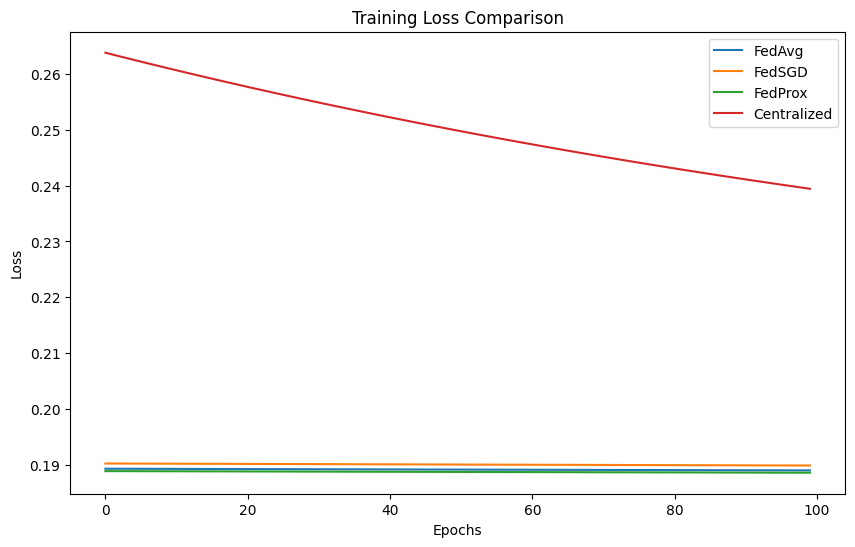

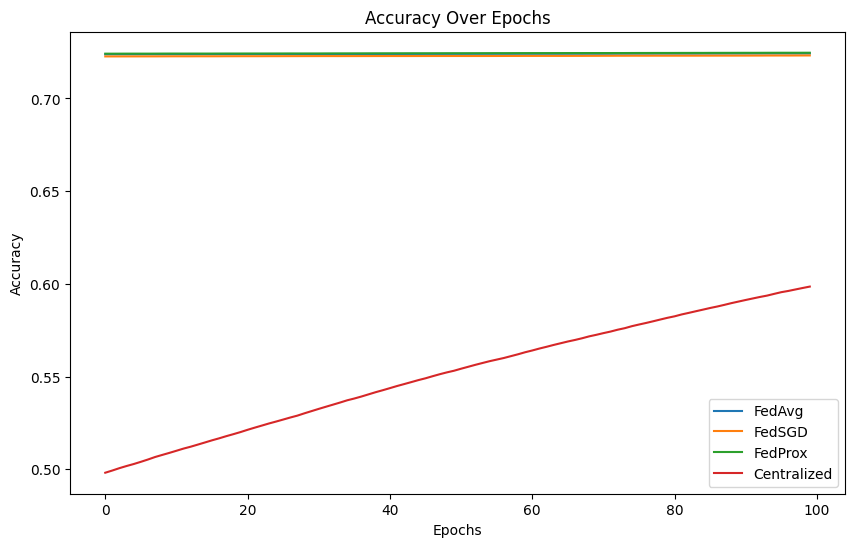

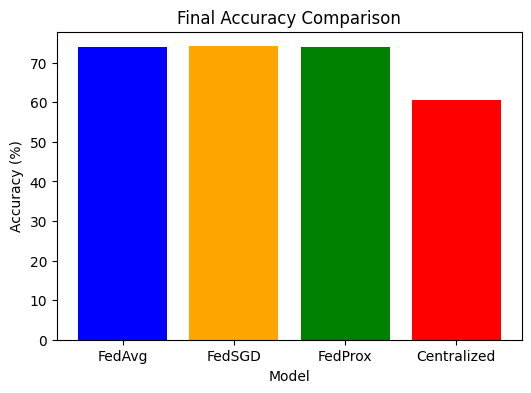

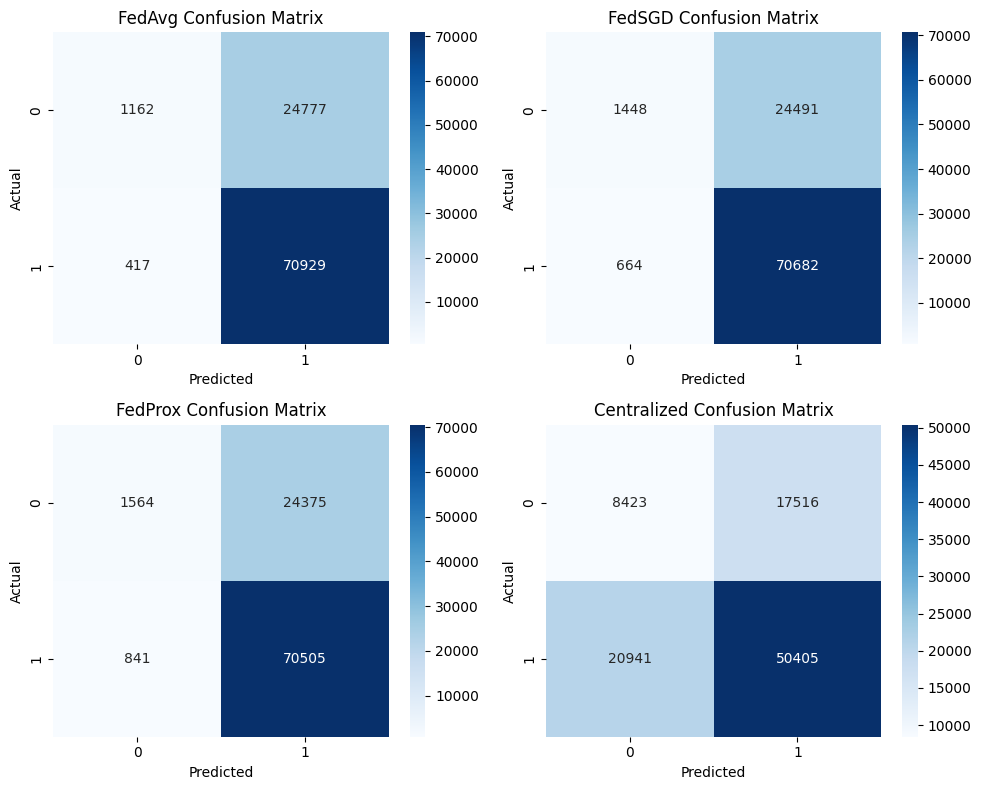


FedAvg Model Accuracy: 74.10%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.04      0.08     25939
           1       0.74      0.99      0.85     71346

    accuracy                           0.74     97285
   macro avg       0.74      0.52      0.47     97285
weighted avg       0.74      0.74      0.65     97285


FedSGD Model Accuracy: 74.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.06      0.10     25939
           1       0.74      0.99      0.85     71346

    accuracy                           0.74     97285
   macro avg       0.71      0.52      0.48     97285
weighted avg       0.73      0.74      0.65     97285


FedProx Model Accuracy: 74.08%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.06      0.11     25939
           1       0.74      0.99      0.85     71346

    accuracy       

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.special import softmax
import random
import pickle

# Load Dataset
file_path = "/Users/uday/Downloads/mydata1.csv"
df = pd.read_csv(file_path, delimiter=",", on_bad_lines="skip", low_memory=False)

# Ensure 'Infinium_Design_Type' exists
if 'Infinium_Design_Type' not in df.columns:
    raise ValueError("Column 'Infinium_Design_Type' not found in the dataset.")

# Encode Infinium_Design_Type as Target Variable
label_encoder = LabelEncoder()
df['Infinium_Design_Type'] = label_encoder.fit_transform(df['Infinium_Design_Type'].astype(str))

# Ensure sequences have a fixed length
SEQ_LENGTH = 10  

def one_hot_encode(seq, length=SEQ_LENGTH):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    encoded = np.array([mapping.get(nuc, [0, 0, 0, 0]) for nuc in seq[:length]])
    if len(encoded) < length:
        padding = np.zeros((length - len(encoded), 4))
        encoded = np.vstack((encoded, padding))
    return encoded.flatten()

# Apply encoding
df['Forward_Sequence'] = df['Forward_Sequence'].astype(str).apply(lambda x: one_hot_encode(x))
df['SourceSeq'] = df['SourceSeq'].astype(str).apply(lambda x: one_hot_encode(x))

# Convert features
df['MAPINFO'] = pd.to_numeric(df['MAPINFO'], errors='coerce').fillna(0.0)
df['Strand'] = df['Strand'].map({'+': 1, '-': 0}).fillna(0).astype(int)
df['MAPINFO'] = (df['MAPINFO'] - df['MAPINFO'].mean()) / df['MAPINFO'].std()

# Prepare feature matrix X and target y
X = np.stack(df[['MAPINFO', 'Strand']].values)
one_hot_features = np.stack(df['Forward_Sequence'].values)
source_seq_features = np.stack(df['SourceSeq'].values)
X = np.hstack([X, one_hot_features, source_seq_features])

y = df['Infinium_Design_Type'].values.reshape(-1, 1)  # New target variable

# Split train-test
test_size = len(X) // 5
X_train, X_test = X[test_size:], X[:test_size]
y_train, y_test = y[test_size:], y[:test_size]

# Non-IID Data Distribution
num_clients = 5
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Define Training Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(output, target):
    return (output - target) * output * (1 - output)

def train_local(X, y, weights, epochs=100, lr=0.01):
    losses = []
    accuracies = []
    for _ in range(epochs):
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        error = sigmoid_derivative(predictions, y)
        loss = np.mean((predictions - y) ** 2)
        losses.append(loss)

        y_pred = np.round(predictions)
        accuracy = accuracy_score(y, y_pred)
        accuracies.append(accuracy)

        adjustments = np.dot(X.T, error) / len(X)
        weights -= lr * adjustments
    return weights, losses, accuracies

# Initialize Global Weights
input_size = X.shape[1]
weights_global = {
    "FedAvg": np.random.randn(input_size, 1) * np.sqrt(1 / input_size),
    "FedSGD": np.random.randn(input_size, 1) * np.sqrt(1 / input_size),
    "FedProx": np.random.randn(input_size, 1) * np.sqrt(1 / input_size),
    "Centralized": np.random.randn(input_size, 1) * np.sqrt(1 / input_size)
}

losses_global = {key: [] for key in weights_global.keys()}
accuracies_global = {key: [] for key in weights_global.keys()}

# Federated Learning Rounds
for round in range(50):
    for method in ["FedAvg", "FedSGD", "FedProx"]:
        local_weights = []
        local_losses = []
        local_accuracies = []
        for i in range(num_clients):
            new_weights, loss, accuracy = train_local(client_data[i], client_labels[i], weights_global[method].copy())
            local_weights.append(new_weights)
            local_losses.append(loss)
            local_accuracies.append(accuracy)

        weights_global[method] = np.mean(local_weights, axis=0)
        losses_global[method] = np.mean(local_losses, axis=0)
        accuracies_global[method] = np.mean(local_accuracies, axis=0)

# Centralized Training
weights_global["Centralized"], losses_global["Centralized"], accuracies_global["Centralized"] = train_local(X_train, y_train, weights_global["Centralized"].copy(), epochs=100)


# Testing the Models
def predict(X, weights):
    z = np.dot(X, weights)
    return np.round(sigmoid(z))

results = {}
for model_name, weights in weights_global.items():
    y_pred = predict(X_test, weights)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = {
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred)
    }
    print(f"{model_name} Model Accuracy: {accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{results[model_name]['confusion_matrix']}")
    print(f"Classification Report:\n{results[model_name]['classification_report']}")

# Plot Training Loss Comparison
plt.figure(figsize=(10, 6))
for method, loss in losses_global.items():
    plt.plot(loss, label=method)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(10, 6))
for method, acc in accuracies_global.items():
    plt.plot(acc, label=method)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# Final Accuracy Comparison (Bar Graph)
plt.figure(figsize=(6, 4))
plt.bar(results.keys(), [res["accuracy"] * 100 for res in results.values()], color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Final Accuracy Comparison")
plt.show()

# Confusion Matrices for All Models
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, (model_name, res) in enumerate(results.items()):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Print Accuracy and Classification Reports
for model_name, res in results.items():
    print(f"\n{model_name} Model Accuracy: {res['accuracy'] * 100:.2f}%")
    print(f"Classification Report:\n{res['classification_report']}")

import pickle

# Find the best model based on accuracy
best_model_name = max(results, key=lambda model: results[model]["accuracy"])
best_weights = weights_global[best_model_name]

# Save only the best model
best_model_filename = f"best_model2.pkl"
with open(best_model_filename, "wb") as f:
    pickle.dump(best_weights, f)
print(f"Best model '{best_model_name}' saved as {best_model_filename}")


In [29]:
import numpy as np
import pickle
import os
import time
from phe import paillier

# Define file names
best_model_name = "best_model2.pkl"
client_update_path = "client_update2.pkl"
keys_path = "paillier_keys.pkl"

# Generate or load Paillier key pair

if os.path.exists(keys_path):
    with open(keys_path, "rb") as f:
        keypair = pickle.load(f)
        public_key, private_key = keypair  # Fix: Unpack as a tuple
    print("✅ Loaded Paillier Key Pair!")
else:
    public_key, private_key = paillier.generate_paillier_keypair()
    with open(keys_path, "wb") as f:
        pickle.dump((public_key, private_key), f)  # Fix: Store as a tuple
    print("🔑 Generated New Paillier Key Pair!")


# Save the public key for the client
with open("public_key.pkl", "wb") as f:
    pickle.dump(public_key, f)

# Load or initialize the global model
if os.path.exists(best_model_name):
    with open(best_model_name, "rb") as f:
        global_model = pickle.load(f)
    print(f"✅ Loaded Best Model from {best_model_name}!")
else:
    input_size = 82  # Adjust based on your data
    num_classes = 24  # Adjust based on your labels
    global_model = np.random.randn(input_size, num_classes) * np.sqrt(1 / input_size)
    print(f"🚀 Initialized New Model (No Best Model Found)!")

print("\n🌍 Server is running and waiting for encrypted client updates...")

# Wait for client update
while not os.path.exists(client_update_path):
    time.sleep(1)

# Load encrypted client weights
with open(client_update_path, "rb") as f:
    encrypted_client_weights = pickle.load(f)

print(f"\n📩 Received encrypted update from client!")

# Decrypt updates
decrypted_client_weights = np.array(
    [private_key.decrypt(weight) for weight in encrypted_client_weights]
).reshape(global_model.shape)

print(f"🔓 Decrypted Client Weights (First 10 Values): {decrypted_client_weights.flatten()[:10]}")

# Print global model before update
print(f"\n🟢 Global Model Before Update (First 10 Values): {global_model.flatten()[:10]}")

# Federated Averaging (FedAvg) aggregation
global_model = (global_model + decrypted_client_weights) / 2

# Print global model after update
print(f"\n🟢 Global Model After Update (First 10 Values): {global_model.flatten()[:10]}")

# Save updated best model
with open(best_model_name, "wb") as f:
    pickle.dump(global_model, f)

print(f"\n✅ Best Model updated successfully!")

# Remove processed client update
os.remove(client_update_path)


✅ Loaded Paillier Key Pair!
✅ Loaded Best Model from best_model2.pkl!

🌍 Server is running and waiting for encrypted client updates...

📩 Received encrypted update from client!
🔓 Decrypted Client Weights (First 10 Values): [-0.06095143  0.13460317  0.07599633  0.11069986 -0.1087181   0.00351549
  0.21032405  0.02215842  0.00344333  0.05279365]

🟢 Global Model Before Update (First 10 Values): [-0.03674981  0.14492646  0.07394751  0.11053448 -0.11437239  0.01061285
  0.22212022  0.01775435  0.0190788   0.05453009]

🟢 Global Model After Update (First 10 Values): [-0.04885062  0.13976481  0.07497192  0.11061717 -0.11154524  0.00706417
  0.21622213  0.01995639  0.01126106  0.05366187]

✅ Best Model updated successfully!


In [28]:
import numpy as np
import pickle
import os
import time
from phe import paillier

# Define file paths
best_model_name = "best_model2.pkl"
public_key_path = "public_key.pkl"
client_update_path = "client_update2.pkl"

# Wait for the global model
while not os.path.exists(best_model_name):
    print("⏳ Waiting for the global model...")
    time.sleep(2)

# Load the global model
with open(best_model_name, "rb") as f:
    global_weights = pickle.load(f)

# Load the public Paillier key
while not os.path.exists(public_key_path):
    print("⏳ Waiting for the public key...")
    time.sleep(2)

with open(public_key_path, "rb") as f:
    public_key = pickle.load(f)

print("\n🤖 Client started training on local data...")

# Print global model before training
print(f"\n🟢 Global Model Before Training (First 10 Values): {global_weights.flatten()[:10]}")

# Simulated local training (updating weights slightly)
client_weights = global_weights + np.random.randn(*global_weights.shape) * 0.01

print("\n✅ Local training completed!")
print(f"🔢 Updated Weights After Training (First 10 Values): {client_weights.flatten()[:10]}")

# Encrypt weights before sending to the server
encrypted_client_weights = np.array([public_key.encrypt(w) for w in client_weights.flatten()])

# Save encrypted update for the server
with open(client_update_path, "wb") as f:
    pickle.dump(encrypted_client_weights, f)

print("\n📤 Sending encrypted update to the server...")
print(f"✅ Encrypted update sent successfully! (First 10 Encrypted Values Shown Below)")
print(encrypted_client_weights[:10])



🤖 Client started training on local data...

🟢 Global Model Before Training (First 10 Values): [-0.03674981  0.14492646  0.07394751  0.11053448 -0.11437239  0.01061285
  0.22212022  0.01775435  0.0190788   0.05453009]

✅ Local training completed!
🔢 Updated Weights After Training (First 10 Values): [-0.06095143  0.13460317  0.07599633  0.11069986 -0.1087181   0.00351549
  0.21032405  0.02215842  0.00344333  0.05279365]

📤 Sending encrypted update to the server...
✅ Encrypted update sent successfully! (First 10 Encrypted Values Shown Below)


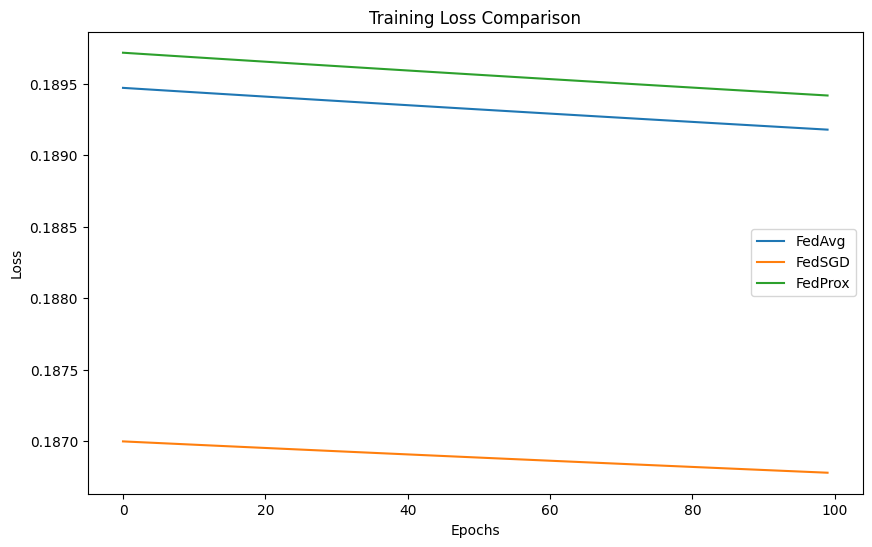

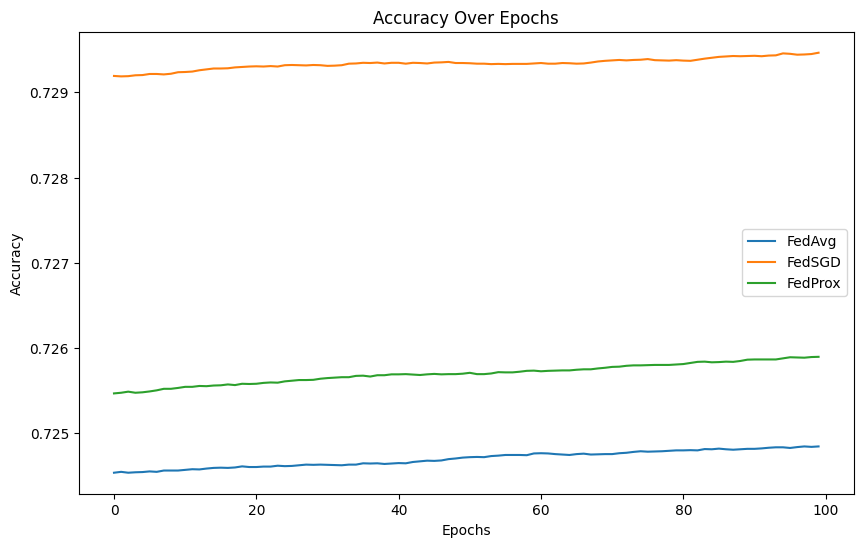

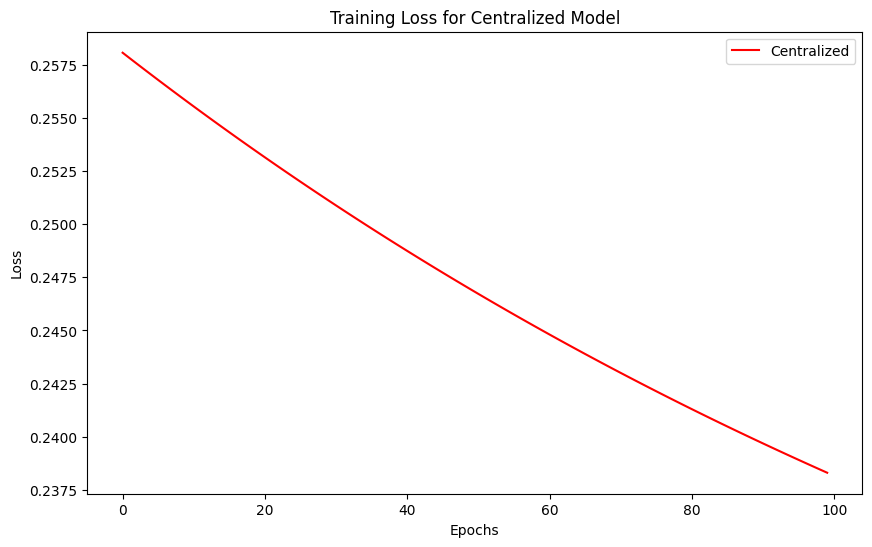

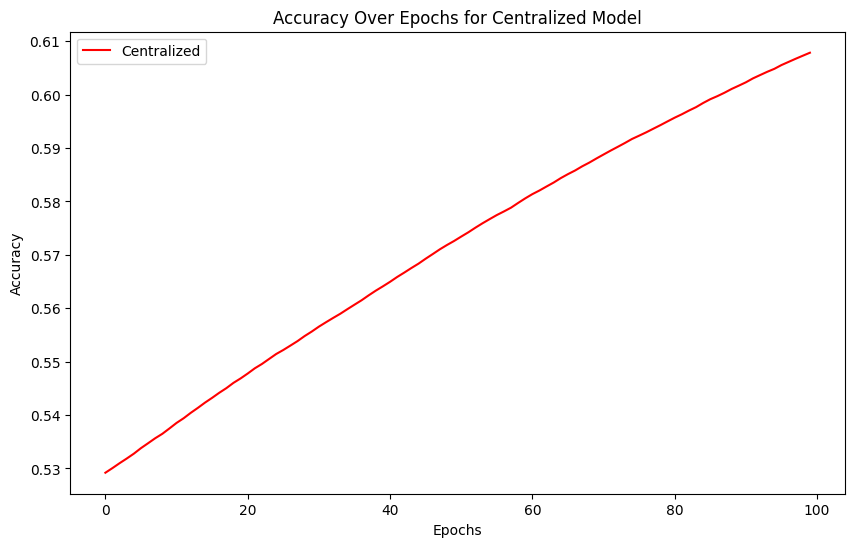

In [52]:
# Plot Training Loss Comparison
plt.figure(figsize=(10, 6))
for method, loss in losses_global.items():
    if method != "Centralized":  # Exclude Centralized model
        plt.plot(loss, label=method)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(10, 6))
for method, acc in accuracies_global.items():
    if method != "Centralized":  # Exclude Centralized model
        plt.plot(acc, label=method)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# Plot Training Loss for Centralized Model
plt.figure(figsize=(10, 6))
plt.plot(losses_global["Centralized"], label="Centralized", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for Centralized Model")
plt.legend()
plt.show()

# Plot Accuracy Over Epochs for Centralized Model
plt.figure(figsize=(10, 6))
plt.plot(accuracies_global["Centralized"], label="Centralized", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs for Centralized Model")
plt.legend()
plt.show()